In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


In [92]:
stack_fixed = 'MD635'
# stack_fixed = 'MD652'
stack_moving = 'atlasV4'
# stack_moving = 'atlasV3'

In [93]:
classifier_setting = 37
warp_setting = 1

In [94]:
registration_settings

upstream_warp_id transform_type  terminate_thresh  \
warp_id                                                     
1                   None         affine          0.000010   
2                      1          rigid          0.000010   
4                      1          rigid          0.000001   
5                      1          rigid          0.000001   
6                      1         affine          0.000010   
7                   None          rigid          0.000001   
8                      1          rigid          0.000001   
10                  None          rigid          0.000010   
11                     1         affine          0.000010   

         grad_computation_sample_number  grid_search_sample_number  std_tx_um  \
warp_id                                                                         
1                              100000.0                     1000.0       2000   
2                              100000.0                    10000.0        100   
4                              100000.0                    10000.0        100   
5                              100000.0                    10000.0        100   
6                              100000.0                    10000.0        100   
7                              100000.0                     1000.0         50   
8                              100000.0                    10000.0        200   
10                             100000.0                     1000.0        100   
11                             100000.0                    10000.0        100   

         std_ty_um  std_tz_um  std_theta_xy_degree surround_weight  \
warp_id                                                              
1             2000       2000                   30               0   
2              100        100                   30               0   
4              100        100                   10               0   
5              100        100                   30         inverse   
6              100        100                   30            -0.5   
7               50         50                   10               0   
8              200        200                   30         inverse   
10             100        100                   30               0   
11             100        100                   30            -0.1   

         regularization_weight  
warp_id                         
1                          NaN  
2                          NaN  
4                     0.000001  
5                     0.000000  
6                     0.000000  
7                          NaN  
8                     0.000000  
10                         NaN  
11                    0.000000

In [172]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
# std_theta_xy = 0
print std_tx, std_ty, std_tz, std_theta_xy

surround_weight = -1.
include_surround = surround_weight != 0

upstream_warp_id                    None
transform_type                    affine
terminate_thresh                   1e-05
grad_computation_sample_number    100000
grid_search_sample_number           1000
std_tx_um                           2000
std_ty_um                           2000
std_tz_um                           2000
std_theta_xy_degree                   30
surround_weight                        0
regularization_weight                NaN
Name: 1, dtype: object
135.869565217 135.869565217 135.869565217 0.523598775598


In [173]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 10
MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [174]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True, volume_type='score', 
                                                      include_surround=True)

print volume_moving[1].shape

File does not exist: /shared/CSHL_volumes/atlasV4/atlasV4_down32_annotationVolume/atlasV4_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_outerContour.bp && mkdir -p /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes


Child returned 0
Child returned 1
0.62 seconds.
File does not exist: /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_outerContour.bp /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_outerContour.bp
rm -rf /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_outerContour_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_outerContour_surround_200.bp /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_outerContour_surround_200.bp


Child returned 1
0.56 seconds.
File does not exist: /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_outerContour_surround_200.bp
Score volume for outerContour_surround_200 does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5.bp && mkdir -p /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5.bp /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5.bp


Child returned 1
0.56 seconds.
File does not exist: /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5_surround_200.bp /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5_surround_200.bp
(373, 432, 369)


Child returned 1
0.55 seconds.
File does not exist: /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5_surround_200.bp
Score volume for sp5_surround_200 does not exist.
Volume shape: (373, 432, 369)


In [98]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting, 
                                                   sided=False, volume_type='score')

print volume_fixed[1].shape

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp


Child returned 0
Child returned 1
0.44 seconds.
File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp
(445, 655, 397)


Child returned 1
0.45 seconds.
File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (445, 655, 397)


In [35]:
# START experimental

In [36]:
all_loaded_structures_sided = structure_to_label_moving.keys()
all_loaded_structures = set([convert_to_unsided_label(s) for s in all_loaded_structures_sided])

In [ ]:
import networkx as nx
from scipy.spatial.distance import squareform
from itertools import permutations

structure_center_locations = {s: np.mean(np.where(DataManager.load_original_volume(stack=stack_moving, structure=s, downscale=32)), axis=1)
              for s in all_loaded_structures_sided}
structure_names = structure_center_locations.keys()
structure_distances = squareform(pdist(structure_center_locations.values()))

In [ ]:
def find_n_dispersed_structures(n, thresh):
    g = nx.from_numpy_matrix(structure_distances > thresh)
    k_cliques = [frozenset([structure_names[i] for i in c]) for c in nx.find_cliques(g) if len(c) >= n]
    return set(k_cliques)
#     k_cliques = [[structure_names[i] for i in c] for c in nx.enumerate_all_cliques(g) if len(c) == n]
#     return k_cliques

In [ ]:
structure_subsets = find_n_dispersed_structures(10, 100)

In [ ]:
print list(structure_subsets)[0]
print len(structure_subsets)

In [ ]:
structure_subsets

In [15]:
# End experimental

In [213]:
# structure_subset = ['7N_L', '7N_R', '12N', '5N_L', 'Pn_R', 'SNR_L', 'VLL_R', '7n_L', 'Tz_R', 'VCA_L', 'VCP_R']
# structure_subset = ['7N_L', '7N_R', '12N', '5N_L','5N_R','Pn_L', 'Pn_R', 'SNR_L', 'SNR_R', 'VLL_L', 'VLL_R', '7n_L',
#           '7n_R', 'Tz_L', 'Tz_R', 'VCA_L', 'VCP_R']
# structure_subset = ['7N_L', '7N_R', '12N', '5N_L','5N_R','Pn_L', 'Pn_R', 'SNR_L', 'SNR_R', 
#                     'VLL_L', 'VLL_R', '7n_L', '7n_R', 'Tz_L', 'Tz_R', 
#                     'VCA_L', 'VCA_R', 'VCP_L', 'VCP_R']
structure_subset = ['7N_L', '7N_R', '12N', '5N_L', '5N_R', 'SNR_R', 
                    'VLL_L', 'VLL_R', '7n_L', '7n_R', 'Tz_L', 'Tz_R', 
                    'VCA_L', 'VCA_R', 'VCP_L', 'VCP_R']

# For MD635, Pn is top noisy. Using it causes registration to stuck in wrong maxima.

if include_surround:
    structure_subset = structure_subset + [convert_to_surround_name(s, margin=200) for s in structure_subset]

# structure_subset = label_to_structure_moving.values()

In [214]:
label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset}

# label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
#                      for label_m, name_m in label_to_structure_moving.iteritems()}

In [215]:
# volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

In [216]:
# structures_sorted_by_size = [x[1] for x in sorted((s, label_to_structure_moving[l]) for l, s in volume_moving_structure_sizes.iteritems())]
# print structures_sorted_by_size

In [217]:
if isinstance(surround_weight, int) or isinstance(surround_weight, float):
    label_weights_m = {label_m: surround_weight if is_surround_label(name_m) else 1. \
                   for label_m, name_m in label_to_structure_moving.iteritems()}
else:
    sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

# Compute Registration

In [218]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [219]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[structure_to_label_moving['7N_L']])

m: [ 216.   186.5  184.5] f: [ 216.   186.5  184.5]


In [220]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, structure=label_to_structure_fixed[ind_f],
                                                          classifier_setting=classifier_setting)
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [221]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins

set([2, 5, 7, 8, 21, 25, 26, 27, 28])


load gradient 2: 4.825353 seconds
load gradient 5: 4.855501 seconds
load gradient 7: 4.401017 seconds
load gradient 8: 5.906589 seconds
load gradient 21: 3.417009 seconds
load gradient 25: 3.576306 seconds
load gradient 26: 5.252910 seconds
load gradient 27: 4.827949 seconds
load gradient 28: 3.543810 seconds
overall: 40.607383 seconds


In [222]:
aligner.set_label_weights(label_weights=label_weights_m)

In [223]:
# For rigid, 
# grad_computation_sample_number = 1e5 is desired
# grid_search_iteration_number and grid_search_sample_number seem to be unimportant as well, set to 100
# lr1=10, lr2=.1 is best

# For affine, 
# lr2 = .001 is too slow; 0.1 rises faster than 0.01
# lr1 does not matter
# plateus around iteration 100, but keep rising afterwards.
# grad_computation_sample_number does not make a difference

# while True:

trial_num = 1

T_all_trials = []
scores_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(type=transform_type, max_iter_num=MAX_ITER_NUM, history_len=HISTORY_LEN, 
                                     terminate_thresh=terminate_thresh,
                                     grid_search_iteration_number=MAX_GRID_SEARCH_ITER_NUM,
                                     grid_search_sample_number=grid_search_sample_number,
                                     grid_search_eta=3.,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=lr1, lr2=lr2,
                                     std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=std_theta_xy)
                
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)

grid search: 36.092887 seconds
tx_best: 86.49 (voxel), ty_best: 24.27, tz_best: 6.27, theta_xy_best: -2.83 (deg)
sigma_tx: 135.87 (voxel), sigma_ty: 135.87, sigma_tz: 135.87, sigma_theta_xy: 30.00 (deg)
-inf 0.165889
grid search: 27.655818 seconds
tx_best: 86.49 (voxel), ty_best: 24.27, tz_best: 6.27, theta_xy_best: -2.83 (deg)
sigma_tx: 97.35 (voxel), sigma_ty: 97.35, sigma_tz: 97.35, sigma_theta_xy: 21.50 (deg)
grid search: 20.030780 seconds
tx_best: 86.49 (voxel), ty_best: 24.27, tz_best: 6.27, theta_xy_best: -2.83 (deg)
sigma_tx: 69.76 (voxel), sigma_ty: 69.76, sigma_tz: 69.76, sigma_theta_xy: 15.40 (deg)
grid search: 14.610159 seconds
tx_best: 86.49 (voxel), ty_best: 24.27, tz_best: 6.27, theta_xy_best: -2.83 (deg)
sigma_tx: 49.98 (voxel), sigma_ty: 49.98, sigma_tz: 49.98, sigma_theta_xy: 11.04 (deg)
grid search: 11.104761 seconds
tx_best: 94.83 (voxel), ty_best: 21.74, tz_best: 7.41, theta_xy_best: -4.90 (deg)
sigma_tx: 35.81 (voxel), sigma_ty: 35.81, sigma_tz: 35.81, sigma_theta

params_best_upToNow [ 84.43435545  23.65076452  14.96158192  -0.18822392]


T: [ 94.39984055  13.6544352    4.96366084]
step: 1.66 seconds
score: 0.223479
iteration 1
T: [ 102.19191549   12.48974591    8.30201699]
step: 1.63 seconds
score: 0.051126
iteration 2
T: [ 109.46977889   16.72149129    9.77673538]
step: 1.65 seconds
score: 0.088662
iteration 3
T: [ 107.18648531   21.6172032    11.49177783]
step: 1.65 seconds
score: 0.110338
iteration 4
T: [ 110.34710693   15.09947924    4.58231731]
step: 1.65 seconds
score: 0.116002
iteration 5
T: [ 105.69763649   20.00353642   10.76376306]
step: 1.63 seconds
score: 0.087286
iteration 6
T: [ 100.58124215   21.10174418    9.55122487]
step: 1.65 seconds
score: 0.122037
iteration 7
T: [ 105.19439227   21.22472571   13.10417609]
step: 1.65 seconds
score: 0.116652
iteration 8
T: [ 100.38278577   18.12413004    7.1776953 ]
step: 1.68 seconds
score: 0.113261
iteration 9
T: [ 99.04795464  22.26387805  14.08764491]
step: 1.65 seconds
score: 0.101916
iteration 10
T: [ 103.65882342   17.56778275   11.34132236]
step: 1.68 seconds

T: [ 77.25216519  30.71571322  18.45197697]
step: 1.65 seconds
score: 0.166308
iteration 90
T: [ 77.22548451  30.85043662  18.50462235]
step: 1.64 seconds
score: 0.166733
iteration 91
T: [ 76.93433425  30.98192702  18.19663493]
step: 1.65 seconds
score: 0.166755
iteration 92
T: [ 76.7537698   31.28054909  18.91157946]
step: 1.65 seconds
score: 0.166622
iteration 93
T: [ 76.31923282  31.21917346  18.07783365]
step: 1.65 seconds
score: 0.165457
iteration 94
T: [ 76.85429956  31.04134794  18.78333136]
step: 1.64 seconds
score: 0.165953
iteration 95
T: [ 76.14928928  31.42656989  17.86318098]
step: 1.64 seconds
score: 0.165299
iteration 96
T: [ 76.50325727  31.34084898  18.94268933]
step: 1.64 seconds
score: 0.166125
iteration 97
T: [ 76.20467244  31.65323978  18.06257032]
step: 1.64 seconds
score: 0.165255
iteration 98
T: [ 76.50891392  31.47308792  18.3257954 ]
step: 1.64 seconds
score: 0.166717
iteration 99
T: [ 76.04833087  31.65109044  17.65449183]
step: 1.64 seconds
score: 0.166472
i

KeyboardInterrupt: 

In [ ]:
# plt.plot(np.arange(30), std_tx*np.exp(-np.arange(30)/3.));
# plt.xlabel('Iteration');
# plt.ylabel('Search radius (voxel)');
# plt.title('Grid search radius shrinking schedule');
# plt.show();

inliers [0 1 3]
Widest standard deviation of converged translation parameters for different trials: 0.25 voxels, 3.74 um


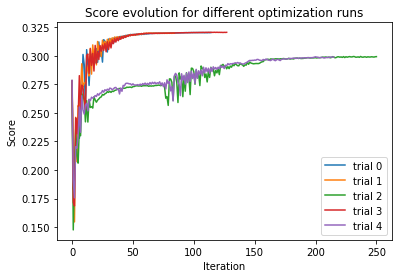

In [23]:
converged_scores = np.array([s[-1] for s in scores_all_trials])
q3 = np.percentile(converged_scores, 55)
q1 = np.percentile(converged_scores, 45)
iqr = q3 - q1
inlier_min = q1 - 1.5 * iqr
inlier_max = q3 + 1.5 * iqr
inliers = np.where((converged_scores > inlier_min) & (converged_scores < inlier_max))[0]
print 'inliers', inliers

plt.figure();
for trial_idx, scores in enumerate(scores_all_trials):
    plt.plot(scores, label='trial ' + str(trial_idx));
plt.xlabel('Iteration');
plt.ylabel('Score');
plt.legend();
plt.title('Score evolution for different optimization runs');

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
T_all_trials = np.array(T_all_trials)
t_std = np.std(pca.fit_transform(T_all_trials[inliers[:,None] ,[3,7,11]])[0])
t_std_um = t_std * XY_PIXEL_DISTANCE_TB
print 'Widest standard deviation of converged translation parameters for different trials: %.2f voxels, %.2f um' % (t_std, t_std_um)

# tx_std = np.std(T_all_trials[inliers, 3])
# ty_std = np.std(T_all_trials[inliers, 7])
# tz_std = np.std(T_all_trials[inliers, 11])
# tx_std_um = tx_std * XY_PIXEL_DISTANCE_TB
# ty_std_um = ty_std * XY_PIXEL_DISTANCE_TB
# tz_std_um = tz_std * XY_PIXEL_DISTANCE_TB
# print 'tx std:', tx_std, 'voxels', tx_std_um, 'um'
# print 'ty std:', ty_std, 'voxels', ty_std_um, 'um'
# print 'tz std:', tz_std, 'voxels', tz_std_um, 'um'

# plt.scatter(np.ones((5,)), np.array(T_all_trials)[:, 3], marker='+');
# plt.scatter(2*np.ones((5,)), np.array(T_all_trials)[:, 7], marker='+');
# plt.scatter(3*np.ones((5,)), np.array(T_all_trials)[:, 11], marker='+');

Best trial: 0
0.285271900706 0.285116697662
[[  8.56772160e-01   3.63717298e-01  -7.52014900e-04   6.62169624e+01]
 [ -3.74484271e-01   1.00117856e+00  -5.81270593e-02   1.17824353e+01]
 [ -2.51314396e-02   5.43714137e-02   1.02753687e+00   9.53365742e+00]]


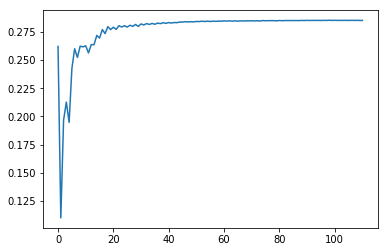

In [87]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [22]:
# print T.reshape((3,4))
# plt.plot(scores);
# print max(scores), scores[-1]

# Export parameters and score plots

In [84]:
for trial_idx in range(trial_num):
    
    T = T_all_trials[trial_idx]
    scores = scores_all_trials[trial_idx]
    
    params_fp = \
    DataManager.get_alignment_parameters_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                  classifier_setting_m=classifier_setting,
                                                  classifier_setting_f=classifier_setting,
                                                  warp_setting=warp_setting,
                                                  trial_idx=trial_idx)
    DataManager.save_alignment_parameters(params_fp, T, 
                                          aligner.centroid_m, aligner.centroid_f,
                                          aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                          aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
    upload_from_ec2_to_s3(params_fp)
    
    history_fp = DataManager.get_score_history_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                          classifier_setting_m=classifier_setting,
                                                          classifier_setting_f=classifier_setting,
                                                          warp_setting=warp_setting,
                                                          trial_idx=trial_idx)
    bp.pack_ndarray_file(np.array(scores), history_fp)
    upload_from_ec2_to_s3(history_fp)

    score_plot_fp = \
    DataManager.get_alignment_score_plot_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                         classifier_setting_m=classifier_setting,
                                                         classifier_setting_f=classifier_setting,
                                                         warp_setting=warp_setting,
                                                         trial_idx=trial_idx)
    fig = plt.figure();
    plt.plot(scores);
    plt.savefig(score_plot_fp, bbox_inches='tight')
    plt.close(fig)

    upload_from_ec2_to_s3(score_plot_fp)

aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_parameters.txt


Child returned 0
0.81 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_scoreHistory.bp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_scoreHistory.bp


Child returned 0
0.70 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_scoreEvolution.png


Child returned 0
0.81 seconds.


# Draw Results

In [88]:
# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (affine_components_to_vector(-9.77304587,  48.73149657,  -2.80149108,  -0.16628751), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# ([1,0,0,0,0,1,0,0,0,0,1,0], 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [89]:
# Transform moving volume, sided, without surround

structure = '7N_L'

vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

volume_m_alignedTo_f = \
transform_volume(vol=vol_m, global_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f,
                  xdim_f=xdim_f, ydim_f=ydim_f, zdim_f=zdim_f)

In [90]:
# Set colors for different contour level
levels = [0.1, 0.25, 0.5, 0.75, .99]
level_colors = {level: (int(level*255),0,0) for level in levels}

0 654 0 444 100 496
rm -rf /shared/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F47-2016.05.19-03.19.48_MD635_1_0139_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg && mkdir -p /shared/CSHL_scoremaps_down32_viz/7N/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F47-2016.05.19-03.19.48_MD635_1_0139_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg /shared/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F47-2016.05.19-03.19.48_MD635_1_0139_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg


Child returned 0
Child returned 0
0.68 seconds.
Child returned 0


rm -rf /shared/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F48-2016.05.19-03.40.12_MD635_3_0144_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg && mkdir -p /shared/CSHL_scoremaps_down32_viz/7N/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F48-2016.05.19-03.40.12_MD635_3_0144_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg /shared/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F48-2016.05.19-03.40.12_MD635_3_0144_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg


Child returned 0
0.62 seconds.


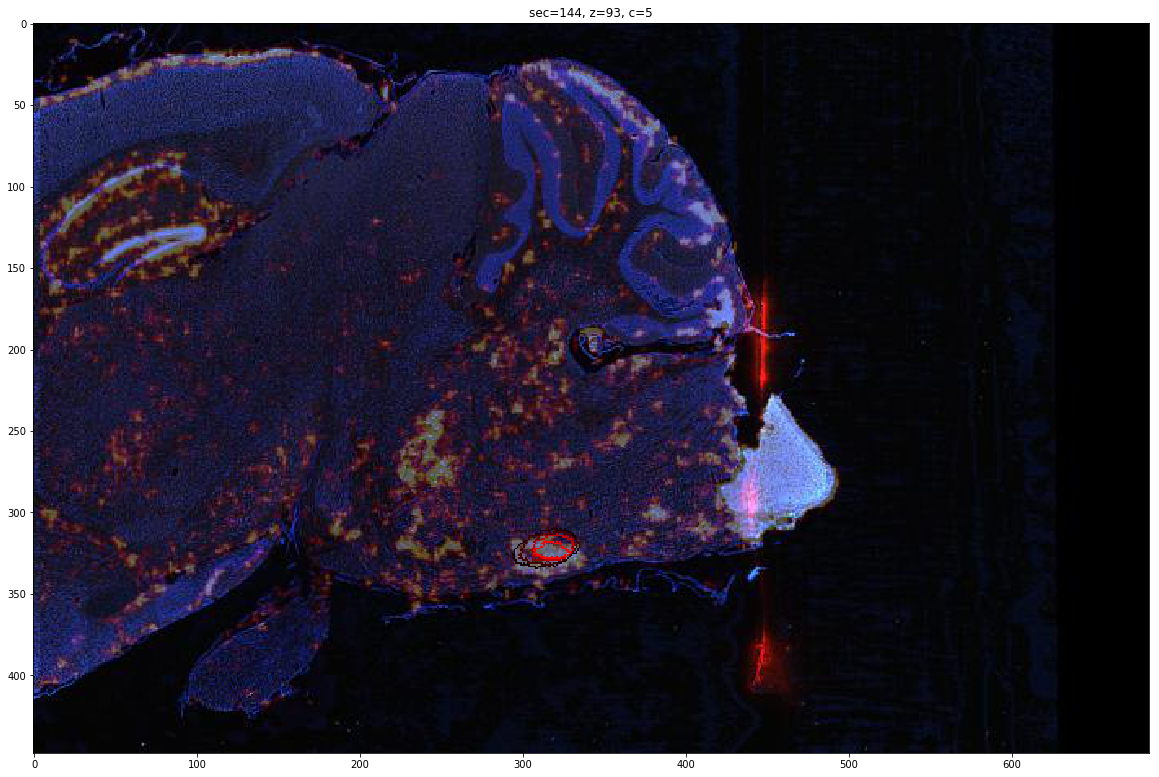

rm -rf /shared/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F50-2016.05.23-14.45.07_MD635_2_0149_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg && mkdir -p /shared/CSHL_scoremaps_down32_viz/7N/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F50-2016.05.23-14.45.07_MD635_2_0149_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg /shared/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F50-2016.05.23-14.45.07_MD635_2_0149_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg


Child returned 0
Child returned 0
0.74 seconds.


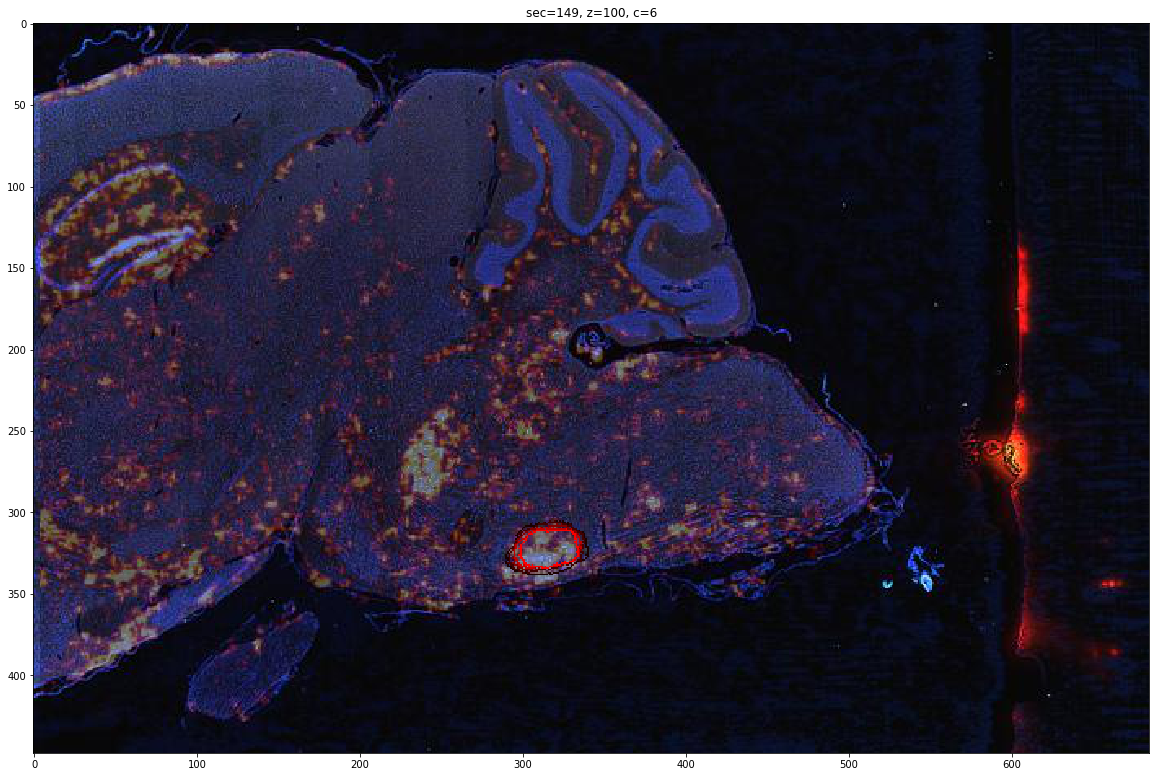

rm -rf /shared/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F52-2016.05.23-15.23.47_MD635_1_0154_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg && mkdir -p /shared/CSHL_scoremaps_down32_viz/7N/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F52-2016.05.23-15.23.47_MD635_1_0154_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg /shared/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F52-2016.05.23-15.23.47_MD635_1_0154_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg


Child returned 0
Child returned 0
0.62 seconds.


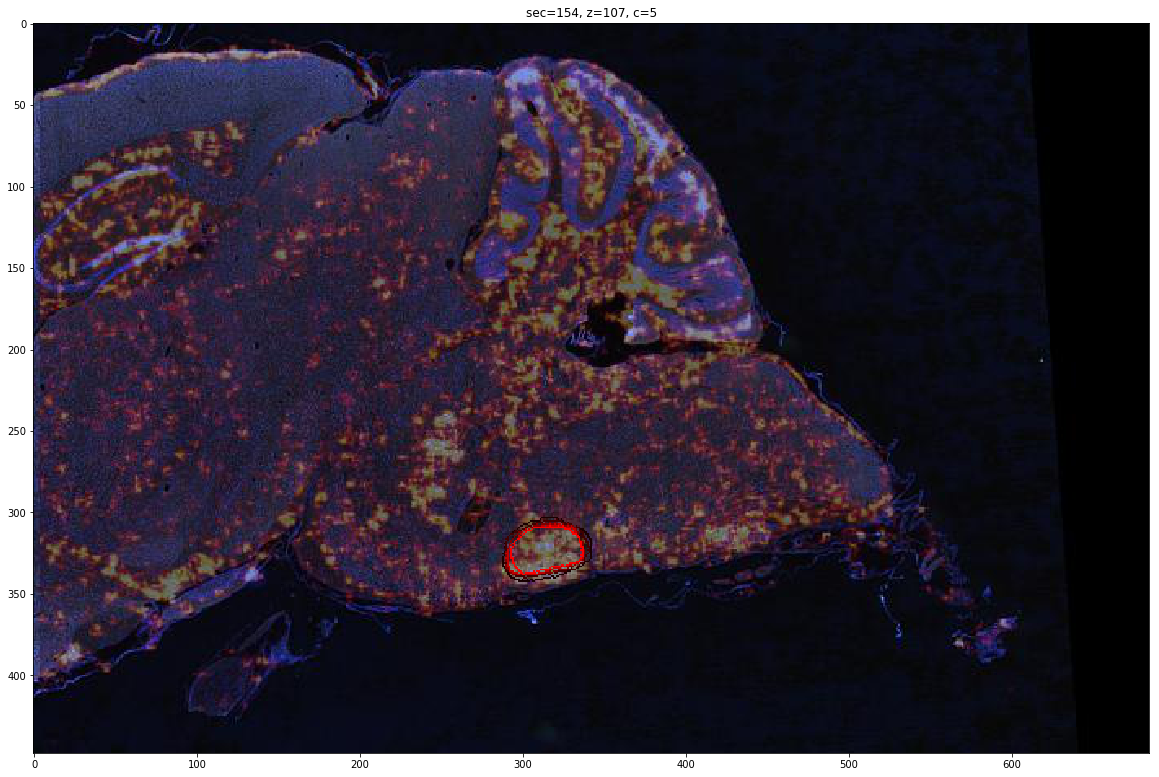

rm -rf /shared/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F53-2016.05.19-05.14.50_MD635_3_0159_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg && mkdir -p /shared/CSHL_scoremaps_down32_viz/7N/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F53-2016.05.19-05.14.50_MD635_3_0159_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg /shared/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F53-2016.05.19-05.14.50_MD635_3_0159_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg


Child returned 0
Child returned 0
0.67 seconds.


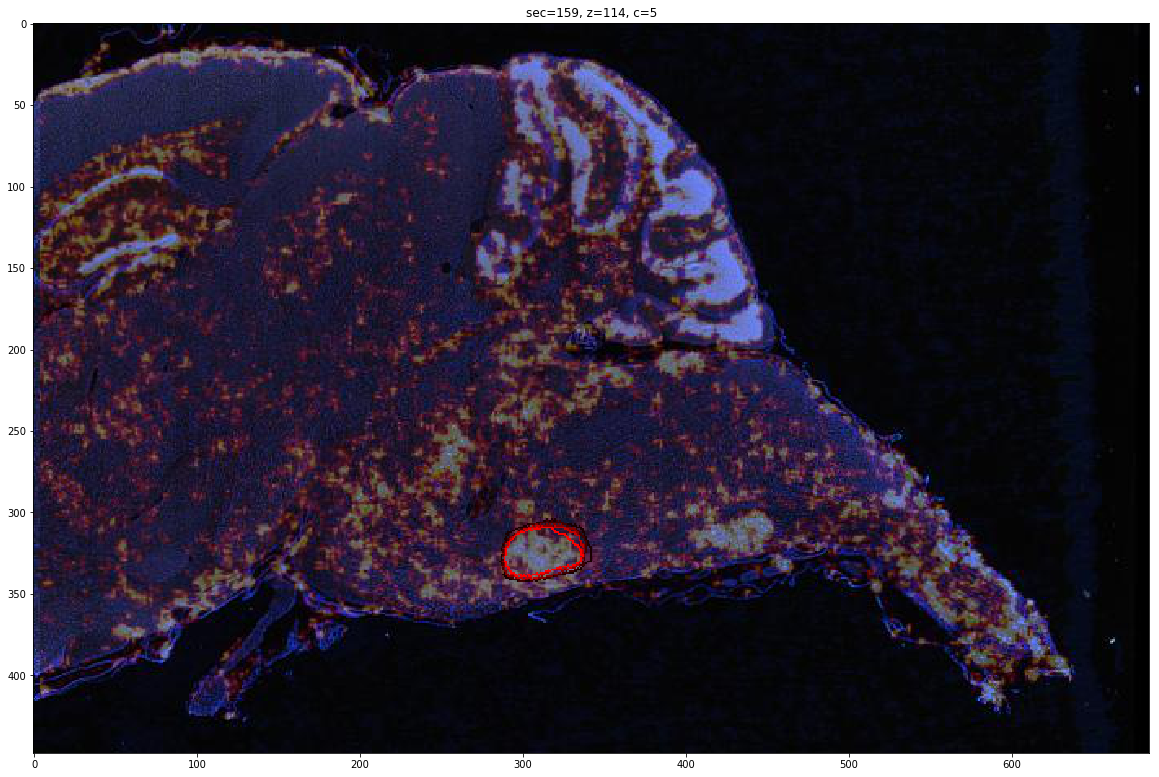

rm -rf /shared/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F56-2016.05.19-06.13.54_MD635_1_0166_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg && mkdir -p /shared/CSHL_scoremaps_down32_viz/7N/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F56-2016.05.19-06.13.54_MD635_1_0166_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg /shared/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F56-2016.05.19-06.13.54_MD635_1_0166_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg


Child returned 0
Child returned 0
0.64 seconds.


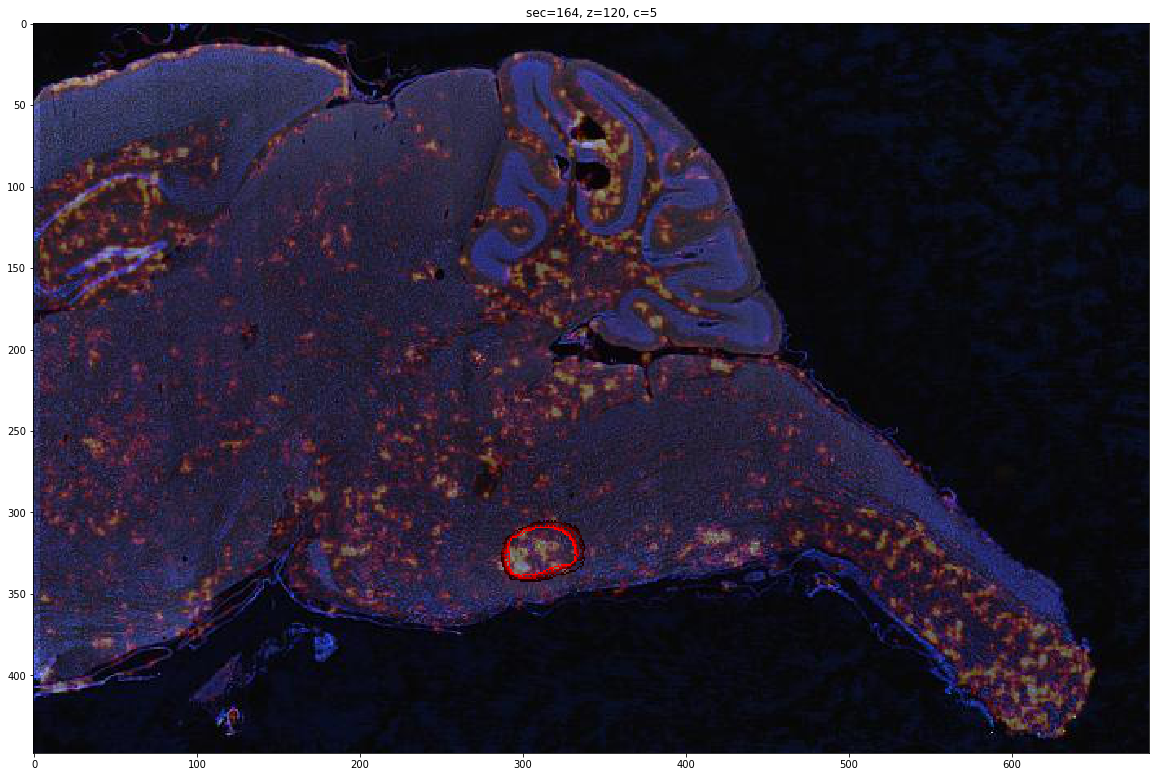

rm -rf /shared/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F58-2016.05.19-06.52.57_MD635_2_0173_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg && mkdir -p /shared/CSHL_scoremaps_down32_viz/7N/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F58-2016.05.19-06.52.57_MD635_2_0173_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg /shared/CSHL_scoremaps_down32_viz/7N/MD635/MD635-F58-2016.05.19-06.52.57_MD635_2_0173_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_down32_7N_denseScoreMap_setting_37.jpg


Child returned 0
Child returned 0
0.64 seconds.


KeyboardInterrupt: 

In [91]:
# Generate overlay visualization

# For getting correct contour location

xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = \
DataManager.load_original_volume_bbox(stack=stack_fixed, vol_type='score', structure='7N', 
                             downscale=32, classifier_setting=classifier_setting)
print xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f

# Generate atlas overlay image for every section

zf, zl = bbox_3d(volume_m_alignedTo_f)[4:]
sec_first = DataManager.convert_z_to_section(stack=stack_fixed, z=zf, downsample=32)
sec_last = DataManager.convert_z_to_section(stack=stack_fixed, z=zl, downsample=32)

for sec in range(sec_first, sec_last+1, 5):
# for sec in [155]:
    
    if is_invalid(metadata_cache['sections_to_filenames'][stack_fixed][sec]):
        continue
    
    try:
#         img = DataManager.load_image(stack=stack_fixed, section=sec, resol='thumbnail', version='cropped_tif')
        sc_viz_fp = DataManager.get_scoremap_viz_filepath(stack=stack_fixed, section=sec, 
                                                           downscale=32,
                                                           structure=convert_to_original_name(structure), 
                                                           classifier_id=classifier_setting)
        download_from_s3(sc_viz_fp)
        img = imread(sc_viz_fp)
    except:
        sys.stderr.write('Error loading scoremap for section %d\n' % sec)
        continue
    
    viz = img.copy()
    
    z1, z2 = DataManager.convert_section_to_z(stack=stack_fixed, sec=sec, downsample=32)
    z = int(z1)
    
    # Find moving volume annotation contours
    c = 0
    vol = volume_m_alignedTo_f
    for level in levels:
        cnts = find_contours(vol[..., z], level=level) # rows, cols
        c += len(cnts)
        for cnt in cnts:
            # r,c to x,y
            cnt_on_cropped = cnt[:, ::-1] + (xmin_vol_f, ymin_vol_f)
            cv2.polylines(viz, [cnt_on_cropped.astype(np.int)], True, level_colors[level], 1)
    
    if c > 0:    
        plt.figure(figsize=(20,20));
#         plt.figure();
        plt.title("sec=%d, z=%d, c=%d" % (sec, z, c));
        plt.imshow(viz);
        plt.show();
